In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
import requests
from urllib.parse import urlparse
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import matplotlib
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = './NanumFontSetup_TTF_BARUNGOTHIC/NanumBarunGothic.ttf'
import matplotlib.font_manager as fm
fontprop = fm.FontProperties(fname=font_path, size=18)
import seaborn as sns
import shap

In [2]:
%%time
# Read Data
basedir = './Training/training_data_ver_16/'
training_data_df = pd.read_csv(basedir + 'training_data_ver_16.csv').drop(columns=['주택가격지수']).dropna()
#training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 1500)]
training_data_df.columns = [col.replace(' ','_').replace('·','_') for col in training_data_df.columns]

Wall time: 1min 26s


In [3]:
training_data_df = training_data_df[(training_data_df['가격면적'] >= 200) & (training_data_df['가격면적'] <= 3000)]

In [4]:
training_data_df['호수대비부속건축물면적'] = training_data_df['부속건축물면적'] / training_data_df['총호수']

In [5]:
training_data_df = training_data_df[(training_data_df['호수대비부속건축물면적'] < 100)]

In [6]:
training_data_df = training_data_df.reset_index(drop=True)

In [7]:
cols_to_log = ['총건축면적', '총연면적', '총용적률연면적', '토지면적', '부속건축물면적']
for col in cols_to_log:
    training_data_df[col] = training_data_df[col].apply(np.log1p)

In [8]:
cat_cols_df = pd.read_csv(basedir + 'cat_cols.csv')

In [9]:
cat_cols_list = [col.replace(' ','_').replace('·','_') for col in cat_cols_df['colname'].tolist()]
len(cat_cols_list)

296

In [10]:
cat_cols = [col for col in training_data_df.columns if col in cat_cols_list]
len(cat_cols)

296

In [11]:
cat_cols[:10]

['건물나이',
 'trade_type',
 '표준지여부',
 '지목명',
 '용도지역명1',
 '용도지역명2',
 '토지이동상황',
 '지형높이',
 '지형형상',
 '도로접면']

In [12]:
shap_summary_df = pd.read_csv(basedir + 'shap_over_zero_summary.csv', index_col=[0])
print(shap_summary_df.shape)
shap_summary_df.head()

(359, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
전용면적,40.273990,42.146956,39.633353,38.323717,40.803807,40.236365
층,4.987706,4.935956,4.919495,5.239756,4.192744,4.855131
건축년도,49.386612,50.214193,48.066302,48.907924,51.590228,49.633052
건물나이,2.452695,2.260963,2.447105,2.314964,2.303207,2.355787
year_linear,64.149345,63.297835,63.106450,62.464663,62.957522,63.195163


In [13]:
shap_summary_df = shap_summary_df.sort_values(['shap_summary_mean'], ascending=False)

In [14]:
shap_summary_df.head()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.490254,92.822213,90.753598,88.498100,91.164767,91.345786
공시지가(만원),77.378904,77.740673,79.390852,78.052755,75.882432,77.689123
year_linear,64.149345,63.297835,63.106450,62.464663,62.957522,63.195163
건축년도,49.386612,50.214193,48.066302,48.907924,51.590228,49.633052
전용면적,40.273990,42.146956,39.633353,38.323717,40.803807,40.236365


In [15]:
shap_summary_df.tail(50)

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
기타용지,0.000992,0.001711,0.001502,0.000282,0.002137,0.001325
대학,0.001548,0.001125,0.001170,0.001138,0.001352,0.001266
근린광장,0.002654,0.001960,0.000049,0.000866,0.000740,0.001254
국가하천,0.001089,0.000092,0.001256,0.001518,0.001719,0.001135
국지도로,0.000266,0.000216,0.000000,0.004806,0.000259,0.001109
중심상업지역,0.000957,0.001059,0.000341,0.000986,0.001336,0.000936
도시기타용도지역지구용도지역지구,0.000846,0.002340,0.000366,0.000671,0.000000,0.000845
기타문화시설,0.000221,0.001504,0.000233,0.002092,0.000000,0.000810
기타자동차정류장,0.002618,0.000888,0.000000,0.000000,0.000516,0.000805
공공시설구역,0.000546,0.001025,0.000348,0.000700,0.001061,0.000736


In [16]:
drop_20_tails_df = shap_summary_df.iloc[:-20,:]

In [17]:
print(drop_20_tails_df.shape)
drop_20_tails_df.head()

(339, 6)


,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
trade_type,93.490254,92.822213,90.753598,88.498100,91.164767,91.345786
공시지가(만원),77.378904,77.740673,79.390852,78.052755,75.882432,77.689123
year_linear,64.149345,63.297835,63.106450,62.464663,62.957522,63.195163
건축년도,49.386612,50.214193,48.066302,48.907924,51.590228,49.633052
전용면적,40.273990,42.146956,39.633353,38.323717,40.803807,40.236365


In [18]:
drop_20_tails_df.tail()

,model_0_shap_summary,model_1_shap_summary,model_2_shap_summary,model_3_shap_summary,model_4_shap_summary,shap_summary_mean
주_용도_위험물저장및처리시설_fraction,0.000478,0.000282,0.000309,0.000663,0.000116,0.000370
사방시설,0.000000,0.000641,0.000000,0.000000,0.000554,0.000239
일반산업단지,0.000058,0.000810,0.000000,0.000248,0.000078,0.000239
기타주차장시설,0.000433,0.000000,0.000000,0.000667,0.000056,0.000231
통제보호구역(민통선이남300m),0.000252,0.000272,0.000161,0.000385,0.000066,0.000227


In [19]:
target_cols = ['금액(만원)', '가격면적', 'target_log_transformed', 'targetarea_log_transformed', '지번주소']

In [20]:
training_data_df = training_data_df[drop_20_tails_df.index.tolist()+target_cols]
print(training_data_df.shape)
training_data_df.head()

(3658226, 344)


,trade_type,공시지가(만원),year_linear,건축년도,전용면적,ynorm,xy,x_2nd,주건축물수,층mean,토지이동상황,호수대비연면적,총건축면적,아파트지구,xnorm,호수대비부속건축물면적,옥내자주식대수,총호수,호수대비주차수,층,y_2nd,층norm,용도지역명1,부속건축물면적,지구단위계획구역,가축사육제한구역,지붕_평지붕_fraction,도로접면,층min,건물나이,지형높이,month_sin,공원,옥외자주식대수,(한강)폐기물매립시설_설치제한지역,지형형상,부속건축물수,상대정화구역,y_cos,y_sin,x_cos,x_sin,옥내기계식대수,제1종지구단위계획구역,총외필지수,제2종일반주거지역,정비구역,장애물제한표면구역,제3종일반주거지역,학교,중점경관관리구역,진입표면구역,교육환경보호구역,재정비촉진지구,month_cos,학교환경위생_정화구역,일반상업지역,주_용도_공동주택_fraction,도로,도시지역,주_용도_제2종근린생활시설_fraction,대공방어협조구역,epi점수,일반미관지구,역사문화미관지구,비행안전제2구역(전술),대공방어협조구역(위탁고도77-257m),지붕_철콘지붕_fraction,준공업지역,제1종일반주거지역,벽돌구조_fraction,용도지역명2,중심지미관지구,가로구역별_최고높이_제한지역,방화지구,용도구역기타,주_용도_제1종근린생활시설_fraction,상수원보호기타,중로2류(폭_15M~20M),대로3류(폭_25M~30M),지붕_경사지붕_fraction,주_용도_노유자시설_fraction,자연경관지구,지붕_기와지붕_fraction,공공주택지구,절대보호구역,완충녹지,수평표면구역,준보전산지,공공공지,자연녹지지역,도시철도,비행안전제3구역(전술),건축허가_착공제한지역,주_용도_판매시설_fraction,경관녹지,과밀억제권역,건축선,공공청사,지목명,제한보호구역(후방지역500m),공장설립승인지역,주_용도_업무시설_fraction,소로2류(폭_8M~10M),대공방어협조구역(위탁고도54-236m),녹지,최고고도지구,원추표면구역,고도지구,도시관리계획_입안중,개발행위허가제한지역,주_용도_교육연구시설_fraction,경관지구,준주거지역,도시기타용도지역지구미분류,공장설립제한지역,근린공원,하천,용도구역미분류,국민임대주택단지예정지구,철도,절대정화구역,도시개발구역,재개발구역,공항시설보호지구,주_용도_자동차관련시설_fraction,어린이공원,제한보호구역(전술항공5km),비오톱1등급,역사도심,소로1류(폭_10M~12M),택지개발예정지구,블록구조_fraction,도시기타용도지역지구기타,대로1류(폭_35M~40M),지붕_박공지붕_fraction,표준지여부,중로3류(폭_12M~15M),일반철골구조_fraction,광장,소로3류(폭_8M_미만),국토이용용도지구기타,지붕_철골지붕_fraction,건축용도지역기타,지붕_기타지붕_fraction,주_용도_종교시설_fraction,옥외기계식대수,공익용산지,지붕_슬레이트지붕_fraction,공항소음피해예상지역,보전산지,중로1류(폭_20M~25M),지역특화발전특구,제3종_구역,보행자전용도로,철골철근콘크리트구조_fraction,경량철골구조_fraction,비행안전제6구역(전술),정비구역기타,사회복지시설,기타녹지시설,친환경점수,근린상업지역,제1종전용주거지역,시장,지하세대있음,유통업무설비,초등학교,학교시설보호지구,하수도,도로구역,주차장,재정비촉진지구기타,지붕_판넬지붕_fraction,소공원,비행안전제2구역(지원),전통사찰보존구역,문화재보호구역,산업시설구역,광로3류(폭_40M~50M),주_용도_근린생활시설_fraction,하천구역,지붕_모임지붕_fraction,공용시설보호지구,지하도로,전기공급설비,기타조적구조_fraction,문화재보존영향_검토대상구역,토지거래계약에관한허가구역,광역계획구역,고속철도,개발제한구역,도시개발구역기타,비행안전제5구역(지원),대로2류(폭_30M~35M),사업지역기타,일단의주택단지조성사업지역,유수지,중요시설물보호지구(공용),산업개발진흥지구,기타콘크리트구조_fraction,부설주차장,국가산업단지,조례로정한지역,기타철도시설,조망가로미관지구,주_용도_판매및영업시설_fraction,문화지구,연결녹지,주거환경개선지구,도시지역기타,자연재해위험지구,지붕_스페니쉬기와_fraction,비행안전제3구역(지원),프리케스트콘크리트구조_fraction,임업용산지,제한보호구역,기타공원시설,유치원,주_용도_창고시설_fraction,주_용도_단독주택_fraction,역사문화특화경관지구,개발진흥지구,도서관,특수도로(보행자전용도로),사방지,특정개발진흥지구,주_용도_운동시설_fraction,중학교,비행안전제5구역(전술),일반도로,보전임지,도시자연공원,역사문화환경보존지역,침수위험지구,수도공급시설,광로1류(폭_70M_이상),주_용도_문화및집회시설_fraction,체육시설,철골콘크리트구조_fraction,공동구,교통광장,방송통신시설,유통단지,일반목구조_fraction,문화시설,학교이적지,주_용도_공장_fraction,공익임지,비행안전제4구역(지원),운동장,기타강구조_fraction,도시자연공원구역,(한강)오염행위_제한지역,지원시설구역,주차환경개선지구,지정문화재구역,방재지구,제2종전용주거지역,기타도로시설,4대문안,고등학교,주간선도로,종합의료시설,국립공원,연구시설,유통상업지역,노외주차장,기타용도지역지구기타,택지개발예정지구기타,국가지정문화재구역,방수설비,온천공보호구역,기타시장시설,여객자동차터미널,지하광장,청소년수련시설,주_용도_동.식물관련시설_fraction,홍수관리구역,시장정비구역,공공문화체육시설미분류,지붕_초가지붕_fraction,하수종말처리시설,자동차검사시설,야생생물보호구역,기타도시공간시설,주_용도_숙박시설_fraction,현상변경허가_대상구역,일반철도,조망가로특화경관지구,일반주거지역,자동차정류장,생산녹지지역,주_용도_의료시설_fraction,일단의공업용지조성사업지역,지붕_함석지붕_fraction,지붕_멘사드지붕_fraction,청사,변전소(전원개발사업구역),제방,경관지구기타,공공지원민간임대주택_공급촉진지구,지붕_원형지붕_fraction,재개발구역기타,열공급설비,사고지,공공도서관,문화재보호구역기타,국토이용기타용도지구,기타용지,대학,근린광장,국가하천,국지도로,중심상업지역,도시기타용도지역지구용도지역지구,기타문화시설,기타자동차정류장,공공시설구역,강파이프구조_fraction,폐기물처리시설,기타교통시설,시가지조성사업지역,변전시설,도시고속도로,문화재,소하천구역,기타폐기물처리시설,정비예정구역,주_용도_관광휴게시설_fraction,중심대광장,지붕_금속지붕_fraction,기타구조_fraction,통제보호구역,주_용도_위험물저장및처리시설_fraction,사방시설,일반산업단지,기타주차장시설,통제보호구역(민통선이남300m),금액(만원),가격면적,target_log_transformed,targetarea_log_transformed,지번주소
0,0,921.0,7.666667,1988,77.75,-9048.956121,-5.048499e+07,1.556315e+07,1.0,9.0,0,98.537963,6.27131,0,5579.095707,0.0,0.0,54.0,0.0,2,4.094180e+07,0.222222,0,0.0,0,0,1.0,0,9.0,0,0,-0.866025,0,0.0,0,0,0.0,0,0.390815,-0.920469,0.931294,-0.364267,0.0,0,1.0,0,0,0,0,0,0,0,0,0,-0.500000,0,0,1.0,0,0,0.0,0,0.0,0,0,0,0,0.0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0,0.0,0,0,0.0,0,0,0,0.0,0,0.0,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0,0,0,0,0,0.0,0,0.0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,

# Training

In [21]:
from sklearn.model_selection import KFold, GroupKFold

In [22]:
import lightgbm as lgb

In [23]:
from sklearn.metrics import r2_score

In [24]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [25]:
cat_cols = [col for col in cat_cols if col in training_data_df.columns.tolist()]
len(cat_cols)

254

In [26]:
# Next things to do:
# 1. Do Variance Inflation Factor (VIF) analysis.
# 2. keep the feature with the highest shap value
# 3. Retrain
# 4. Remove 1 feature at a time and find out the set of feature with the lowest loss.
# 5. Retrain
# 6. Continue production prep

Fold 0 start
(2926580, 339)
y dist plot


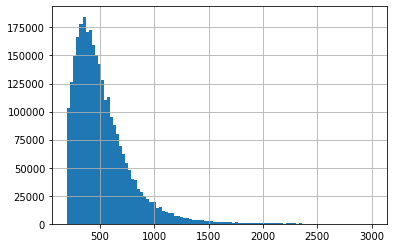

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.876857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8108
[LightGBM] [Info] Number of data points in the train set: 2926580, number of used features: 339


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.640869
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.6288
[100]	valid_0's huber: 64.9989
[150]	valid_0's huber: 58.7477
[200]	valid_0's huber: 55.0631
[250]	valid_0's huber: 52.5516
[300]	valid_0's huber: 50.674
[350]	valid_0's huber: 49.3591
[400]	valid_0's huber: 48.2256
[450]	valid_0's huber: 47.2386
[500]	valid_0's huber: 46.4598
[550]	valid_0's huber: 45.6897
[600]	valid_0's huber: 45.0525
[650]	valid_0's huber: 44.4531
[700]	valid_0's huber: 44.009
[750]	valid_0's huber: 43.5391
[800]	valid_0's huber: 43.1218
[850]	valid_0's huber: 42.7416
[900]	valid_0's huber: 42.3854
[950]	valid_0's huber: 42.1073
[1000]	valid_0's huber: 41.7979
[1050]	valid_0's huber: 41.5133
[1100]	valid_0's huber: 41.2428
[1150]	valid_0's huber: 41.0129
[1200]	valid_0's huber: 40.7689
[1250]	valid_0's huber: 40.553
[1300]	valid_0's huber: 40.35
[1350]	valid_0's huber: 40.1406
[1400]	valid_0's huber: 39.9612
[1450]	valid

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


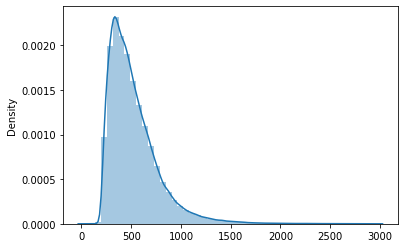

Fold 0 end
Fold 1 start
(2926581, 339)
y dist plot


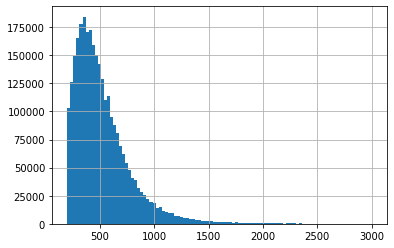

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.852697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8106
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 339


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.755320
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.7086
[100]	valid_0's huber: 64.8658
[150]	valid_0's huber: 58.7338
[200]	valid_0's huber: 54.9327
[250]	valid_0's huber: 52.4645
[300]	valid_0's huber: 50.7083
[350]	valid_0's huber: 49.304
[400]	valid_0's huber: 48.1643
[450]	valid_0's huber: 47.1935
[500]	valid_0's huber: 46.4057
[550]	valid_0's huber: 45.6757
[600]	valid_0's huber: 45.0423
[650]	valid_0's huber: 44.4547
[700]	valid_0's huber: 43.9846
[750]	valid_0's huber: 43.5442
[800]	valid_0's huber: 43.1283
[850]	valid_0's huber: 42.7481
[900]	valid_0's huber: 42.3799
[950]	valid_0's huber: 42.0342
[1000]	valid_0's huber: 41.6947
[1050]	valid_0's huber: 41.4211
[1100]	valid_0's huber: 41.1446
[1150]	valid_0's huber: 40.9359
[1200]	valid_0's huber: 40.6857
[1250]	valid_0's huber: 40.4633
[1300]	valid_0's huber: 40.2679
[1350]	valid_0's huber: 40.0444
[1400]	valid_0's huber: 39.8445
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


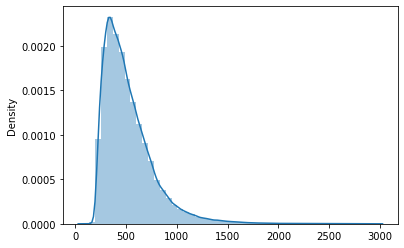

Fold 1 end
Fold 2 start
(2926581, 339)
y dist plot


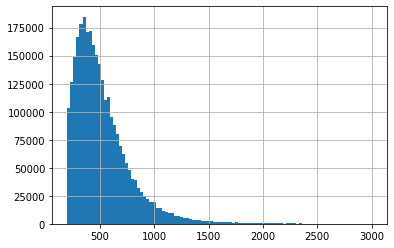

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.840755 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8116
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 339


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.648130
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4875
[100]	valid_0's huber: 64.6769
[150]	valid_0's huber: 58.4537
[200]	valid_0's huber: 54.7904
[250]	valid_0's huber: 52.3593
[300]	valid_0's huber: 50.6889
[350]	valid_0's huber: 49.4144
[400]	valid_0's huber: 48.3067
[450]	valid_0's huber: 47.3434
[500]	valid_0's huber: 46.4878
[550]	valid_0's huber: 45.745
[600]	valid_0's huber: 45.1246
[650]	valid_0's huber: 44.5567
[700]	valid_0's huber: 44.0102
[750]	valid_0's huber: 43.5773
[800]	valid_0's huber: 43.1467
[850]	valid_0's huber: 42.7514
[900]	valid_0's huber: 42.3965
[950]	valid_0's huber: 42.0623
[1000]	valid_0's huber: 41.7649
[1050]	valid_0's huber: 41.462
[1100]	valid_0's huber: 41.2246
[1150]	valid_0's huber: 40.9877
[1200]	valid_0's huber: 40.7329
[1250]	valid_0's huber: 40.5121
[1300]	valid_0's huber: 40.2637
[1350]	valid_0's huber: 40.0358
[1400]	valid_0's huber: 39.8639
[1450]	va

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


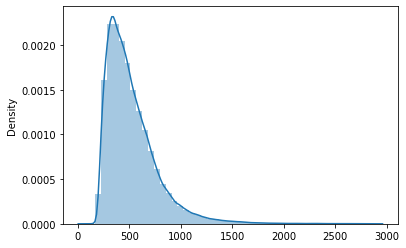

Fold 2 end
Fold 3 start
(2926581, 339)
y dist plot


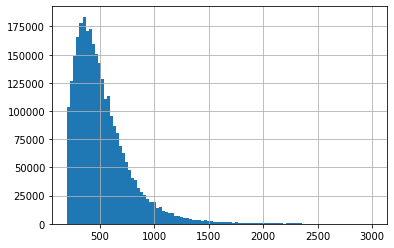

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.824188 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8116
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 339


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.732369
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.4309
[100]	valid_0's huber: 64.8253
[150]	valid_0's huber: 58.6752
[200]	valid_0's huber: 54.9203
[250]	valid_0's huber: 52.5359
[300]	valid_0's huber: 50.7803
[350]	valid_0's huber: 49.4542
[400]	valid_0's huber: 48.3158
[450]	valid_0's huber: 47.318
[500]	valid_0's huber: 46.5786
[550]	valid_0's huber: 45.8082
[600]	valid_0's huber: 45.1378
[650]	valid_0's huber: 44.6022
[700]	valid_0's huber: 44.0952
[750]	valid_0's huber: 43.5896
[800]	valid_0's huber: 43.1814
[850]	valid_0's huber: 42.7853
[900]	valid_0's huber: 42.4305
[950]	valid_0's huber: 42.0813
[1000]	valid_0's huber: 41.7507
[1050]	valid_0's huber: 41.4559
[1100]	valid_0's huber: 41.2179
[1150]	valid_0's huber: 41.0032
[1200]	valid_0's huber: 40.7728
[1250]	valid_0's huber: 40.5732
[1300]	valid_0's huber: 40.3901
[1350]	valid_0's huber: 40.1749
[1400]	valid_0's huber: 39.9976
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


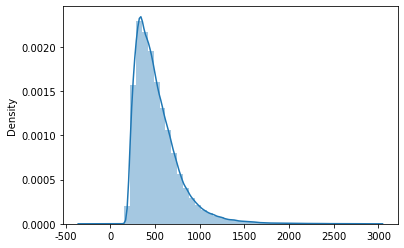

Fold 3 end
Fold 4 start
(2926581, 339)
y dist plot


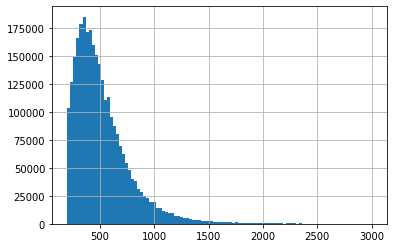

Using categorical_feature in Dataset.


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.799561 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8107
[LightGBM] [Info] Number of data points in the train set: 2926581, number of used features: 339


Overriding the parameters from Reference Dataset.
categorical_column in param dict is overridden.


[LightGBM] [Info] Start training from score 524.646665
Training until validation scores don't improve for 500 rounds
[50]	valid_0's huber: 79.295
[100]	valid_0's huber: 64.6923
[150]	valid_0's huber: 58.6004
[200]	valid_0's huber: 54.8535
[250]	valid_0's huber: 52.3622
[300]	valid_0's huber: 50.5543
[350]	valid_0's huber: 49.2006
[400]	valid_0's huber: 48.1284
[450]	valid_0's huber: 47.1504
[500]	valid_0's huber: 46.3144
[550]	valid_0's huber: 45.6966
[600]	valid_0's huber: 45.0723
[650]	valid_0's huber: 44.5343
[700]	valid_0's huber: 44.0641
[750]	valid_0's huber: 43.5753
[800]	valid_0's huber: 43.1254
[850]	valid_0's huber: 42.7465
[900]	valid_0's huber: 42.4127
[950]	valid_0's huber: 42.0973
[1000]	valid_0's huber: 41.8065
[1050]	valid_0's huber: 41.5186
[1100]	valid_0's huber: 41.2772
[1150]	valid_0's huber: 41.0596
[1200]	valid_0's huber: 40.8475
[1250]	valid_0's huber: 40.5812
[1300]	valid_0's huber: 40.3563
[1350]	valid_0's huber: 40.1225
[1400]	valid_0's huber: 39.9336
[1450]	v

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


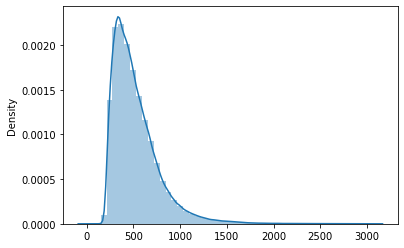

Fold 4 end


<Figure size 432x288 with 0 Axes>

In [28]:
count = 0
oof = np.zeros(training_data_df.shape[0])

shap_summary_df = pd.DataFrame()

for train_idx, val_idx in kf.split(training_data_df):
    print('Fold {} start'.format(count))
    train_data = training_data_df.loc[train_idx]
    val_data = training_data_df.loc[val_idx]
    
    x_train = train_data.drop(columns=target_cols)
    y_train = train_data['가격면적']
    
    print(x_train.shape)
    
    x_val = val_data.drop(columns=target_cols)
    y_val = val_data['가격면적']
    
    print('y dist plot')
    y_train.hist(bins=100)
    plt.show()
    plt.clf()
    
    params = {
        'objective': 'huber',
        'learning_rate': 10,
        'seed': 42,
        'max_depth': 12,
        'num_leaves': 37,
        'lambda_l2': 0,
        'metric': 'huber',
        'num_threads': 6,
    }
    
    train_dataset = lgb.Dataset(x_train, label=y_train, categorical_feature=cat_cols)
    val_dataset = lgb.Dataset(x_val, label=y_val, categorical_feature=cat_cols)
    
    num_rounds = 10000

    bst = lgb.train(params, train_dataset, num_rounds, valid_sets=[val_dataset], early_stopping_rounds=500, verbose_eval=50)
    
    bst.save_model(basedir + 'lightgbm_huber_shap_20_tail_cut_{}.txt'.format(count), num_iteration=bst.best_iteration)
    
    preds = bst.predict(x_val, num_iteration=bst.best_iteration)
    
    print('preds dist plot')
    sns.distplot(preds)
    plt.show()
    plt.clf()
    
    oof[val_idx] = preds
    
    # shap
    explainer = shap.explainers.Tree(bst)
    
    sample_x = x_val.sample(n=1000)
    sample_y = y_val.loc[x_val.index]
    
    shap_values = explainer.shap_values(sample_x, y=sample_y, check_additivity=True, approximate=False)
    shap_values_T = shap_values.T
    
    shap_summary = np.zeros(x_val.shape[1])
    
    for i in range(x_val.shape[1]):
        shap_summary[i] = np.mean(np.abs(shap_values_T[i]))
    
    
    shap_summary_df['model_{}_shap_summary'.format(count)] = shap_summary
        
    
    print('Fold {} end'.format(count))
    count += 1

In [29]:
from sklearn.metrics import mean_squared_error

In [30]:
np.sqrt(mean_squared_error(training_data_df['가격면적'], oof))

66.66634323384177

In [31]:
shap_summary_mean = np.zeros(shap_summary_df.shape[0])
for i in range(shap_summary_df.shape[1]):
    shap_summary_mean += shap_summary_df.iloc[:,i]

In [32]:
shap_summary_mean = shap_summary_mean / shap_summary_df.shape[1]

In [33]:
shap_summary_df['shap_summary_mean'] = shap_summary_mean

In [34]:
shap_summary_df.index = x_train.columns

In [35]:
shap_summary_df.to_csv(basedir + 'shap_20_tail_cut.csv')

In [36]:
#